## Image3Pipeline   (MIRI CALIMAGE3)

`Image3Pipeline` combines the calibrated data from multiple exposures (e.g. a dither or mosaic pattern) into a single rectified (distortion corrected) product. Before being combined, the exposures receive additional corrections for the purpose of astrometric alignment, background matching, and outlier rejection. 

Official documentation for `Image3Pipeline` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image3.html>

The `Image3Pipeline` comprises a linear series of steps. The steps applied to MIRI data in order are:

|Step|Description|
|:---|:---|
|`tweakreg`|refine the WCS solution by comparing source catalogues from input images|
|`skymatch`|compute sky values in a collection of input images that contain both sky and source signal|
|`outlier_detection`|identification of bad pixels or cosmic-rays that remain in each of the input images|
|`resample`|resample using WCS and distortion information into an undistorted product|
|`source_catalog`|resample using WCS and distortion information into an undistorted product|


For more information and examples of each of the steps click on the links in the side bar.

### Input data

An example of running the file through the `Image3Pipeline` is now shown using a simple simulated 4-point dither observation of a galaxy with the MIRI Imager (F1130W filter) produced with [MIRISim v2.1](http://miri.ster.kuleuven.be/bin/view/Public/MIRISimPublicRelease2dot1) and brought to level 2B using the `Detector1Pipeline` and `Image2Pipeline` modules. 

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [8]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call
from jwst import datamodels
from jwst.associations.lib.member import Member
from jwst.associations.asn_from_list import asn_from_list
from astropy.table import Table
from photutils import CircularAperture

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0535.pmap"

`Image3Pipeline` requires an association file as input that lists the exposures to be combined. The content of the association file is printed for inspection. It is assumed the files are in 'IMA_science'

In [10]:
# load the science and background files to lists
my_science_files = glob.glob('IMA_science/*cal.fits')
my_science_files = sorted(my_science_files)

# set the association name
asn_name = 'my_galaxy'

# setup an empty level 2 association structure
asn = asn_from_list(my_science_files, product_name=asn_name)

# set some metadata
asn['asn_pool'] = asn_name + '_pool'
asn['asn_type'] = 'image3'
        
# print the association and save to file
name, ser = asn.dump()
print(ser)

asn_file = asn_name + '_lvl3_asn.json'
with open(asn_file, 'w') as f:
    f.write(ser)

{
    "asn_type": "image3",
    "asn_rule": "DMS_Level3_Base",
    "version_id": null,
    "code_version": "0.13.7",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "target": "none",
    "asn_pool": "my_galaxy_pool",
    "products": [
        {
            "name": "my_galaxy",
            "members": [
                {
                    "expname": "IMA_science/my_galaxy_dither1_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_science/my_galaxy_dither2_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_science/my_galaxy_dither3_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_science/my_galaxy_dither4_cal.fits",
                    "exptype": "science

Import Image2Pipeline and print the docstring to show some information

In [11]:
from jwst.pipeline import Image3Pipeline
print(Image3Pipeline.__doc__)


    Image3Pipeline: Applies level 3 processing to imaging-mode data from
                    any JWST instrument.

    Included steps are:
        tweakreg
        skymatch
        outlier_detection
        resample
        source_catalog
    


The association file is passed as input. The output level 2B files will be saved in `my_output_dir` as `_cal.fits`. 

*Parameters used:*
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file
    
`output_dir` : boolean, optional, default is the working directory   
&nbsp;&nbsp;&nbsp;&nbsp; the location to save the output
    
There are still some issues with the tweakreg step so this is skipped for now. We also set the source detection parameters and explicitly save the output from the `source_catalog` step.


In [20]:
# user specified
my_output_dir = 'demo_output'

# the output directory should be created if it doesn't exist
if not os.path.exists(my_output_dir): 
    os.mkdir(my_output_dir)

# run the pipeline
Image3Pipeline.call(asn_file, save_results=True, output_dir=my_output_dir,
                    steps={'tweakreg':{'skip':True},
                           'source_catalog':{'save_results':True, 'kernel_fwhm': 3.0, 'snr_threshold': 5.}})


2019-07-22 15:54:13,512 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2019-07-22 15:54:13,515 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2019-07-22 15:54:13,517 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2019-07-22 15:54:13,519 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2019-07-22 15:54:13,521 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2019-07-22 15:54:13,523 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2019-07-22 15:54:13,617 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('my_galaxy_lvl3_asn.json',).
2019-07-22 15:54:14,814 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'my_galaxy_dither1_cal.fits' reftypes = ['drizpars']
2019-07-22 15:54:14,819 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/patrickkavanagh/

2019-07-22 15:54:27,068 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).
2019-07-22 15:54:27,075 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_drizpars_0001.fits
2019-07-22 15:54:27,565 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for my_galaxy
2019-07-22 15:54:28,647 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1218, 1177)
2019-07-22 15:54:29,450 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1218, 1177)
2019-07-22 15:54:30,274 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1218, 1177)
2019-07-22 15:54:31,088 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1218, 1177)
2019-07-22 15:54:31,557 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.022925405 -0.018241897 0.022925405 0.019302552 359.986644766 0.019302552 359.98664

We can plot the before (rate) and after (cal) images for the first dither position

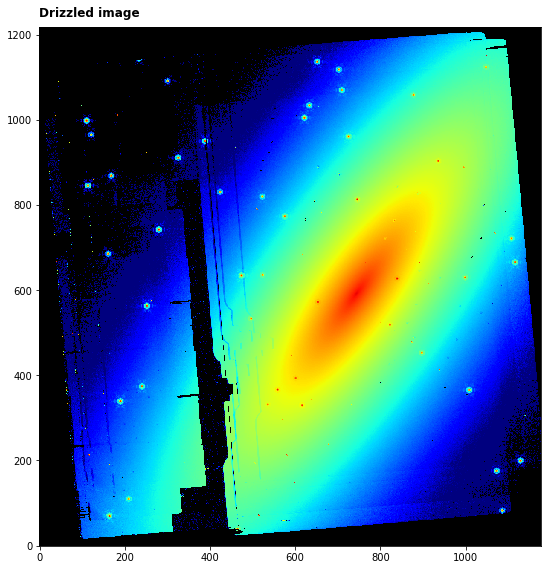

In [21]:
driz_dm = datamodels.open(os.path.join(my_output_dir,'my_galaxy_i2d.fits'))

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1,vmax=1000))
axs.annotate('Drizzled image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()



In [22]:
my_catalog = os.path.join(my_output_dir,'my_galaxy_cat.ecsv')
sources = Table.read(my_catalog, format='ascii.ecsv')

print(sources.columns)    # print all available column names
print()
sources['id', 'xcentroid', 'ycentroid', 'sky_centroid', 'abmag'].pprint(max_width=200)

<TableColumns names=('id','xcentroid','ycentroid','sky_centroid','area','source_sum','source_sum_err','semimajor_axis_sigma','semiminor_axis_sigma','orientation','sky_bbox_ll','sky_bbox_ul','sky_bbox_lr','sky_bbox_ur','orientation_sky','abmag','abmag_error')>

 id     xcentroid          ycentroid                      sky_centroid                      abmag       
           pix                pix                           deg,deg                                     
--- ------------------ ------------------ ------------------------------------------- ------------------
  1  465.3229934248459  40.60037660861897  0.008581976636042724,-0.016990404546913303 16.117643356323242
  2  568.3861471916999  57.92240326194591  0.005405088618397695,-0.016456458821157788 16.889514923095703
  3 164.78982345357352  70.18334474003645  0.017845813136668526,-0.016078518923121045 14.614348411560059
  4  513.9144049289938  72.67112137375418  0.007084162265779488,-0.016001834432487087 14.761037826538086
  5 

2019-07-22 15:54:33,421 - stpipe - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/photutils/aperture/attributes.py:75: AstropyDeprecationWarning: Inputing positions shaped as 2xN is deprecated and will be removed in v0.8.  Positions should be a (x, y) pixel position or a list or array of (x, y) pixel positions, e.g. [(x1, y1), (x2, y2), (x3, y3)].
  '(x2, y2), (x3, y3)].', AstropyDeprecationWarning)



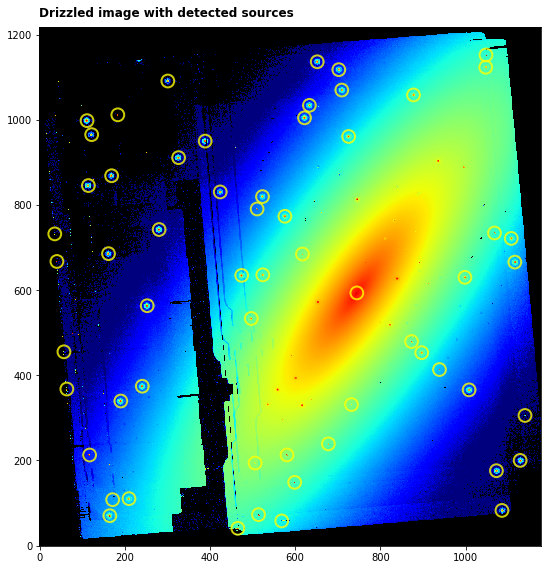

In [23]:
# read source X,Y positions from the table, show with circles of radius 10pix
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=15.)

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1,vmax=1000))
apertures.plot(color='yellow', lw=2.0, alpha=0.8)
axs.annotate('Drizzled image with detected sources', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()

### Command line

To achieve the same result from the command line there are a couple of options. However, one must still generate the association file. In this case, it is best to copy the template above into a text file and save it to `my_galaxy_lvl3_asn.json`. The content is printed here for convenience.

```python
{
    "asn_type": "image3",
    "asn_rule": "DMS_Level3_Base",
    "version_id": null,
    "code_version": "0.13.7",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "target": "none",
    "asn_pool": "my_galaxy_pool",
    "products": [
        {
            "name": "my_galaxy",
            "members": [
                {
                    "expname": "IMA_science/my_galaxy_dither1_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_science/my_galaxy_dither2_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_science/my_galaxy_dither3_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_science/my_galaxy_dither4_cal.fits",
                    "exptype": "science"
                }
            ]
        }
    ]
}
```

**Option 1:**
Run the `Image3Pipeline` class using the `strun` command:

```bash
mkdir demo_output

strun jwst.pipeline.Image3Pipeline my_galaxy_lvl3_asn.json --output_dir demo_output
```

This will produce the same output file in the user-defined `--output_dir`


**Option 2:**
Collect the pipeline configuration files in your working directory (if they are not already there) using `collect_pipeline_configs` and then run the `Image3Pipeline` using the `strun` command with the associated `calwebb_image3.cfg` file. This option is a little more flexible as one can create edit the cfg files, use them again, etc.

```bash
mkdir demo_output

collect_pipeline_cfgs cfgs/

strun cfgs/calwebb_image3.cfg my_galaxy_lvl3_asn.json --output_dir demo_output
```

This will produce the same output file in the user-defined `--output_dir`

## Further examples

Other notebooks with more complex examples can be found here:

*To be added*